# 23-3. Pillow 사용법

In [1]:
import numpy as np
from PIL import Image

data = np.zeros([32, 32, 3], dtype=np.uint8)
image = Image.fromarray(data, 'RGB')
image.show()

In [2]:
data[:, :] = [255, 0, 0]
image = Image.fromarray(data, 'RGB')
image.show()

In [3]:
data = np.zeros([128, 128, 3], dtype=np.uint8)
data[:, :] = [255, 255, 255]
image = Image.fromarray(data, 'RGB')
image.show()

In [4]:
from PIL import Image
import os

# 연습용 파일 경로
image_path = 'python_image_proc/pillow_practice.png'

# 이미지 열기
img = Image.open(image_path)
img.show()

# width와 height 출력
print(img.width)
print(img.height)

# JPG 파일 형식으로 저장해보기
new_image_path = 'python_image_proc/pillow_practice.jpg'
img = img.convert('RGB')
img.save(new_image_path)

620
465


In [5]:
resized_image = img.resize((100,200))
resized_image.show()

resized_image_path = 'python_image_proc/pillow_practice_resized.png'
resized_image.save(resized_image_path)

In [6]:
box = (300, 100, 600, 400)
region = img.crop(box)
region.show()

cropped_image_path = 'python_image_proc/pillow_practice_cropped.png'
region.save(cropped_image_path)

# 23-4. Pillow를 활용한 데이터 전처리

In [7]:
import os
import pickle

dir_path = 'python_image_proc/cifar-100-python'
train_file_path = os.path.join(dir_path, 'train')

with open(train_file_path, 'rb') as f:
    train = pickle.load(f, encoding='bytes')

print(type(train))
#print(train)   # 혹시 내용이 궁금하다면 주석을 풀고 실행해 보세요.

<class 'dict'>


In [8]:
train.keys()

dict_keys([b'filenames', b'batch_label', b'fine_labels', b'coarse_labels', b'data'])

In [9]:
type(train[b'filenames'])

list

In [10]:
train[b'filenames'][0:5]

[b'bos_taurus_s_000507.png',
 b'stegosaurus_s_000125.png',
 b'mcintosh_s_000643.png',
 b'altar_boy_s_001435.png',
 b'cichlid_s_000031.png']

In [11]:
train[b'data'][0:5]

array([[255, 255, 255, ...,  10,  59,  79],
       [255, 253, 253, ..., 253, 253, 255],
       [250, 248, 247, ..., 194, 207, 228],
       [124, 131, 135, ..., 232, 236, 231],
       [ 43,  32,  87, ...,  60,  29,  37]], dtype=uint8)

In [12]:
train[b'data'][0].shape

(3072,)

In [13]:
image_data = train[b'data'][0].reshape([32, 32, 3], order='F')   # order를 주의하세요!!
image = Image.fromarray(image_data)    # Pillow를 사용하여 Numpy 배열을 Image객체로 만들어서
image.show()    # 화면에 띄워 봅시다!!

In [14]:
image_data = image_data.swapaxes(0, 1)
image = Image.fromarray(image_data)
image.show()

In [15]:
import os
import pickle
from PIL import Image
import numpy
from tqdm import tqdm

dir_path = 'python_image_proc/cifar-100-python'
train_file_path = os.path.join(dir_path, 'train')

# image를 저장할 cifar-100-python의 하위 디렉토리(images)를 생성합니다. 
images_dir_path = os.path.join(dir_path, 'images')
if not os.path.exists(images_dir_path):
    os.mkdir(images_dir_path)  # images 디렉토리 생성

# 32X32의 이미지 파일 50000개를 생성합니다. 
with open(train_file_path, 'rb') as f:
    train = pickle.load(f, encoding='bytes')
    for i in tqdm(range(len(train[b'filenames']))):
        filename = train[b'filenames'][i].decode()
        data = train[b'data'][i].reshape([32, 32, 3], order='F')
        image = Image.fromarray(data.swapaxes(0, 1))
        image.save(os.path.join(images_dir_path, filename))

100%|██████████| 50000/50000 [00:14<00:00, 3436.89it/s]


In [16]:
for i in tqdm(range(50000000)):
    pass


100%|██████████| 50000000/50000000 [00:08<00:00, 5665918.43it/s]


# 23-5. OpenCV (1) 안녕, OpenCV

In [17]:
import cv2 as cv
import numpy as np

cap = cv.VideoCapture(0)

while(1):

    # Take each frame
    _, frame = cap.read()

    # Convert BGR to HSV
    hsv = cv.cvtColor(frame, cv.COLOR_BGR2HSV)

    # define range of blue color in HSV
    lower_blue = np.array([110,50,50])
    upper_blue = np.array([130,255,255])

    # Threshold the HSV image to get only blue colors
    mask = cv.inRange(hsv, lower_blue, upper_blue)

    # Bitwise-AND mask and original image
    res = cv.bitwise_and(frame,frame, mask= mask)
    cv.imshow('frame',frame)
    cv.imshow('mask',mask)
    cv.imshow('res',res)
    k = cv.waitKey(5) & 0xFF
    if k == 27:
        break

cv.destroyAllWindows()
cap.release()

# 23-6. OpenCV (2) 톺아보기

Q1. & 0xFF는 어떤 역할을 하는 코드일까요?   
   
넘버락 키가 눌러져있을때 waitKey을 사용하면    
원래는 99 = 1100011 이렇게 나와야하는데   
1048675 = 100000000000001100011   
이런식으로 나와버리니까 & ff (0b11111111 )을 써서    
1100011 = 99를 구함 99가 esc키 의 번호   

# 23-7. 실습 : 비슷한 이미지 찾아내기

In [18]:
import os
import pickle
import cv2
import numpy as np
from matplotlib import pyplot as plt
from tqdm import tqdm

# 전처리 시 생성했던 디렉토리 구조
dir_path = 'python_image_proc/cifar-100-python'
train_file_path = os.path.join(dir_path, 'train')
images_dir_path = os.path.join(dir_path, 'images')

In [19]:
# 파일명을 인자로 받아 해당 이미지 파일과 히스토그램을 출력해 주는 함수
def draw_color_histogram_from_image(file_name):
    image_path = os.path.join(images_dir_path, file_name)
    # 이미지 열기
    img = Image.open(image_path)
    cv_image = cv2.imread(image_path)

    # Image와 Histogram 그려보기
    f=plt.figure(figsize=(10,3))
    im1 = f.add_subplot(1,2,1)
    im1.imshow(img)
    im1.set_title("Image")

    im2 = f.add_subplot(1,2,2)
    color = ('b','g','r')
    for i,col in enumerate(color):
        # image에서 i번째 채널의 히스토그램을 뽑아서(0:blue, 1:green, 2:red)
        histr = cv2.calcHist([cv_image],[i],None,[256],[0,256])   
        im2.plot(histr,color = col)   # 그래프를 그릴 때 채널 색상과 맞춰서 그립니다.
    im2.set_title("Histogram")

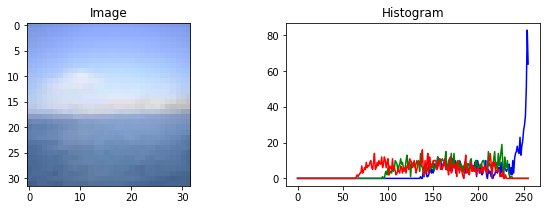

In [20]:
draw_color_histogram_from_image('adriatic_s_001807.png')

### 1개의 이미지를 입력하면 그와 비슷한 이미지 찾아보기

In [21]:
def get_histogram(image):
    histogram = []

    # Create histograms per channels, in 4 bins each.
    for i in range(3):
        channel_histogram = cv2.calcHist(images=[image],
                                         channels=[i],
                                         mask=None,
                                         histSize=[4],  # 히스토그램 구간을 4개로 한다.
                                         ranges=[0, 256])
        histogram.append(channel_histogram)  

    histogram = np.concatenate(histogram)
    #print(sum(histogram))
    #print(histogram)
    histogram = cv2.normalize(histogram, histogram)

    return histogram

In [22]:
# get_histogram() 확인용 코드
filename = train[b'filenames'][0].decode()
file_path = os.path.join(images_dir_path, filename)
image = cv2.imread(file_path)
print(image.shape)
histogram = get_histogram(image)
histogram

(32, 32, 3)


array([[0.3126804 ],
       [0.4080744 ],
       [0.14521089],
       [0.21940625],
       [0.18654831],
       [0.23742512],
       [0.30208108],
       [0.35931748],
       [0.06465594],
       [0.35825753],
       [0.36991683],
       [0.29254165]], dtype=float32)

In [23]:
def build_histogram_db():
    histogram_db = {}

    #디렉토리에 모아 둔 이미지 파일들을 전부 리스트업합니다. 
    path = images_dir_path
    file_list = os.listdir(images_dir_path)

    for file_name in tqdm(file_list):
        file_path = os.path.join(images_dir_path, file_name)
        image = cv2.imread(file_path)

        histogram = get_histogram(image)

        histogram_db[file_name] = histogram

    return histogram_db

In [24]:
histogram_db = build_histogram_db()
histogram_db['adriatic_s_001807.png']

100%|██████████| 49999/49999 [00:05<00:00, 9573.96it/s] 


array([[0.        ],
       [0.        ],
       [0.29744893],
       [0.5828624 ],
       [0.        ],
       [0.17107612],
       [0.41608465],
       [0.29315054],
       [0.        ],
       [0.34301192],
       [0.37224102],
       [0.16505837]], dtype=float32)

In [25]:
def get_target_histogram():
    filename = input("이미지 파일명을 입력하세요: ")
    if filename not in histogram_db:
        print('유효하지 않은 이미지 파일명입니다.')
        return None
    return histogram_db[filename]

In [26]:
target_histogram = get_target_histogram()
target_histogram

이미지 파일명을 입력하세요: abel_s_000096.png


array([[0.17585792],
       [0.409982  ],
       [0.2743807 ],
       [0.22458962],
       [0.12076989],
       [0.43328848],
       [0.31569675],
       [0.21505515],
       [0.15255144],
       [0.36125028],
       [0.35701275],
       [0.21399577]], dtype=float32)

abel_s_000096.png

In [29]:
def search(histogram_db, target_histogram, top_k=5):
    results = {}

    # Calculate similarity distance by comparing histograms.
    for file_name, histogram in tqdm(histogram_db.items()):
        distance = cv2.compareHist(H1=target_histogram,
                                   H2=histogram,
                                   method=cv2.HISTCMP_CHISQR)

        results[file_name] = distance

    results = dict(sorted(results.items(), key=lambda item: item[1])[:top_k])

    return results

In [30]:
result = search(histogram_db, target_histogram)
result

100%|██████████| 49999/49999 [00:00<00:00, 698429.05it/s]


{'abel_s_000096.png': 0.0,
 'panthera_leo_s_000122.png': 0.02994796560572021,
 'castor_fiber_s_000294.png': 0.03254914068899116,
 'lizard_s_000210.png': 0.03331810610041964,
 'possum_s_000097.png': 0.03441729766419806}

In [31]:
def show_result(result):
    f=plt.figure(figsize=(10,3))
    for idx, filename in enumerate(result.keys()):    
        img_path = os.path.join(images_dir_path, filename)
        im = f.add_subplot(1,len(result),idx+1)
        img = Image.open(img_path)
        im.imshow(img)

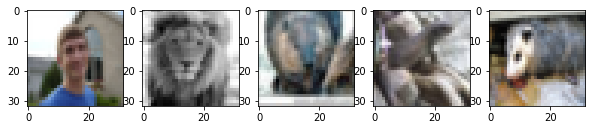

In [32]:
show_result(result)